# How are daily counts distributed?

This notebook seeks a plausible distribution for the daily new cases and new deaths in worldwide [COVID-19 data](https://github.com/CSSEGISandData/COVID-19). The naive Poisson or Binomial distribution appears to be a poor fit. What distribution might we use instead in Pyro's [compartmental models](http://docs.pyro.ai/en/dev/contrib.epidemiology.html)?

In [1]:
import os
import sys
import math
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro.distributions as dist
from pyro.contrib.epidemiology import binomial_dist
from pyro.contrib.epidemiology.distributions import (set_approx_sample_thresh,
                                                     set_relaxed_distributions)

In [2]:
def load_df(basename):
    url = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
           "csse_covid_19_data/csse_covid_19_time_series/")
    local_path = os.path.join("/tmp", basename)
    if not os.path.exists(local_path):
        urllib.request.urlretrieve(url + basename, local_path)
    return pd.read_csv(local_path)

cum_cases_df = load_df("time_series_covid19_confirmed_US.csv")
cum_deaths_df = load_df("time_series_covid19_deaths_US.csv")

In [3]:
print(cum_cases_df.columns[:20])
print(cum_deaths_df.columns[:20])

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20'],
      dtype='object')
Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', 'Population',
       '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20'],
      dtype='object')


Convert to torch.Tensor.

In [4]:
cum_cases = torch.tensor(cum_cases_df.iloc[:, 11:].to_numpy(),
                         dtype=torch.float).contiguous()
cum_deaths = torch.tensor(cum_deaths_df.iloc[:, 12:].to_numpy(),
                          dtype=torch.float).contiguous()
print(cum_cases.shape, cum_deaths.shape)

torch.Size([3261, 150]) torch.Size([3261, 150])


Convert from cumulative to difference data, and clamp to ensure positivity.

In [5]:
new_cases = (cum_cases[:, 1:] - cum_cases[:, :-1]).clamp(min=0)
new_deaths = (cum_deaths[:, 1:] - cum_deaths[:, :-1]).clamp(min=0)
print(f"shape = {tuple(new_cases.shape)}")

shape = (3261, 149)


Let's scatter plot successive pairs of time points.

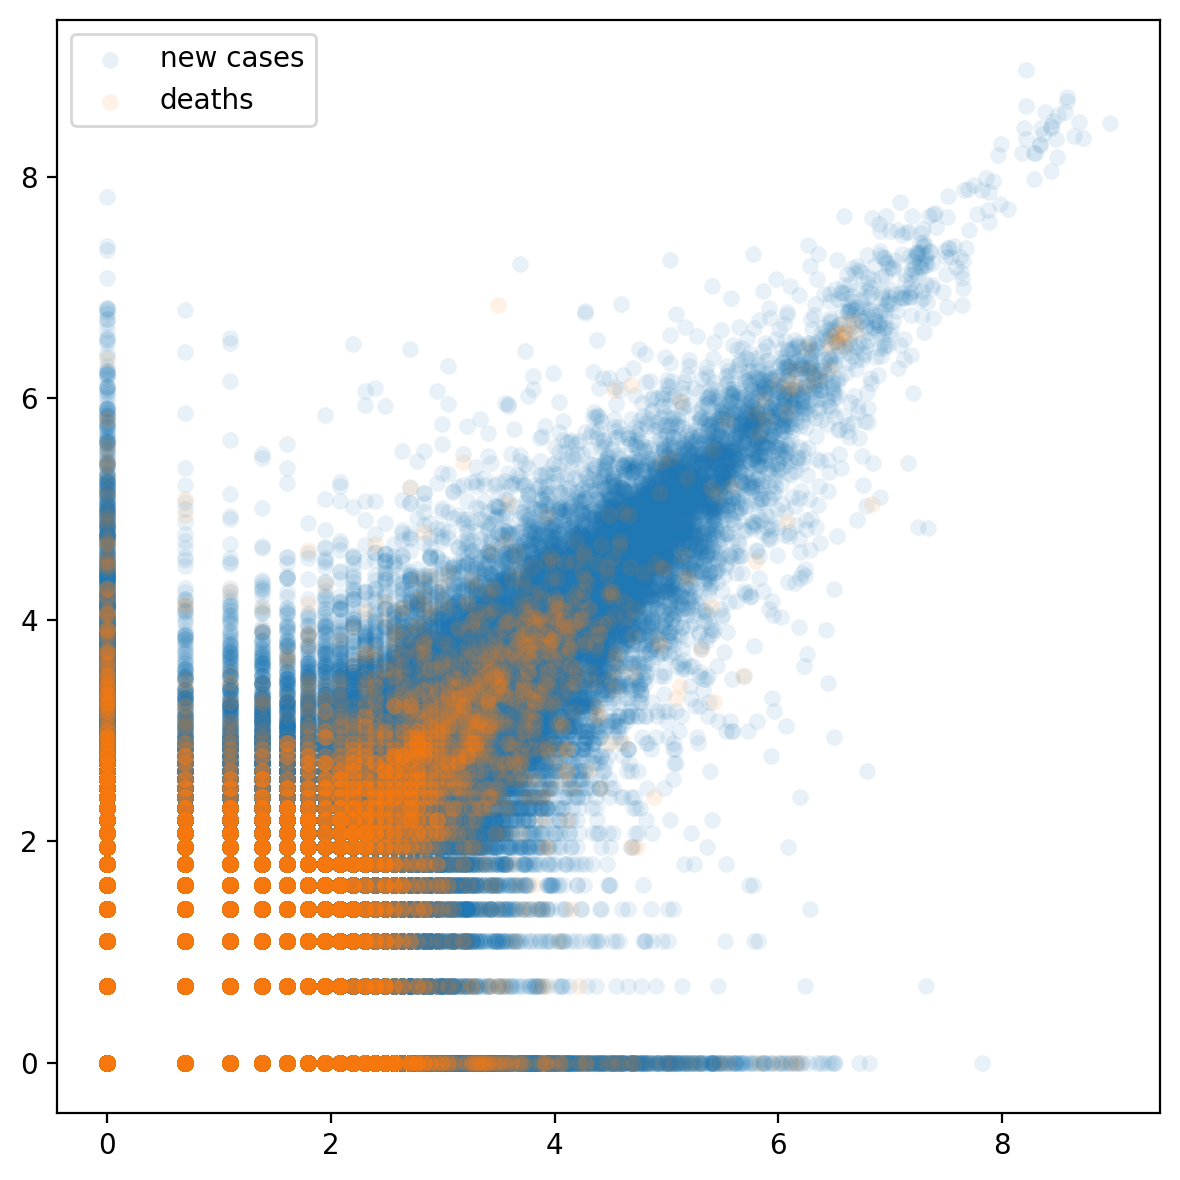

In [6]:
plt.figure(figsize=(6, 6), dpi=200)
plt.scatter(new_cases[:, :-1].log1p(),
            new_cases[:, 1:].log1p(), lw=0, alpha=0.1, label="new cases")
plt.scatter(new_deaths[:, :-1].log1p(),
            new_deaths[:, 1:].log1p(), lw=0, alpha=0.1, label="deaths")
plt.legend(loc="best")
plt.tight_layout()

In [7]:
data = torch.cat([new_cases, new_deaths], dim=0)
print(data.shape)

torch.Size([6522, 149])


Let's instead estimate the mean at one time with the mean of its neighbors.

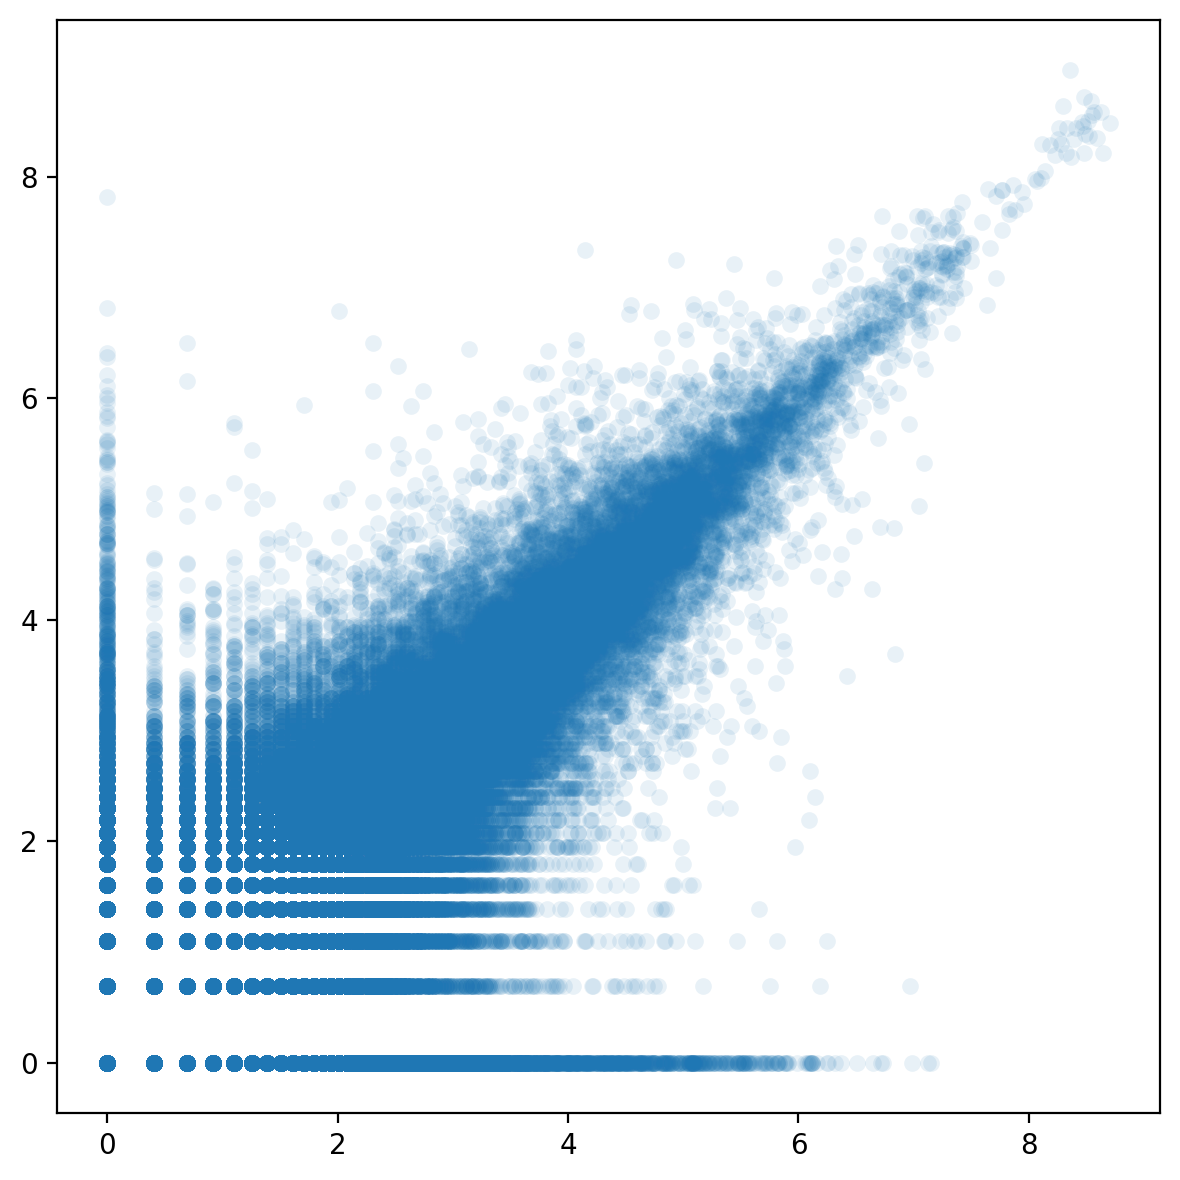

In [8]:
X = (data[:, :-2] + data[:, 2:]).div(2).log1p().reshape(-1)
Y = data[:, 1:-1].log1p().reshape(-1)
assert X.shape == Y.shape

plt.figure(figsize=(6, 6), dpi=200)
plt.scatter(X, Y, lw=0, alpha=0.1, label="new cases")
plt.tight_layout()

Now consider the distributions at various levels. Let's slice at geometrically spaced intervals.

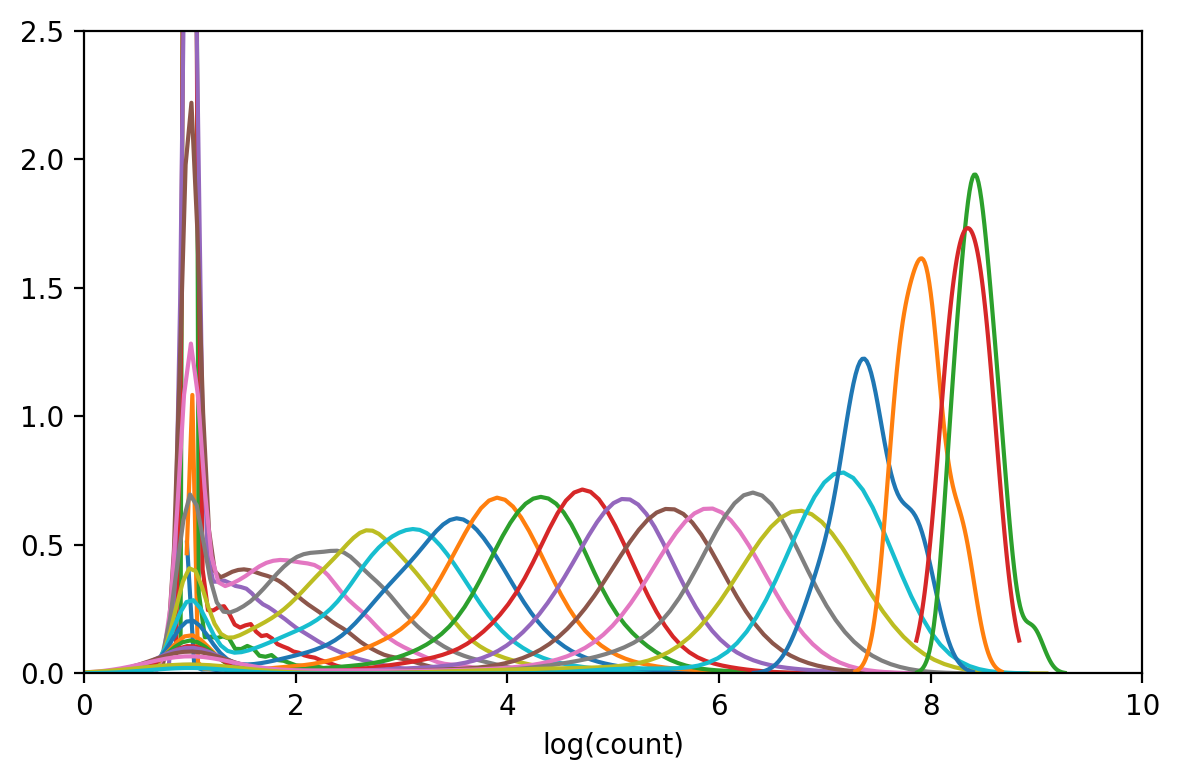

In [9]:
X = (data[:, :-2] + data[:, 2:]).div(2).reshape(-1)
X += torch.rand(X.shape)
Y = (data[:, 1:-1].reshape(-1) + torch.rand(X.shape)).log().clamp(min=1)
plt.figure(figsize=(6, 4), dpi=200)
plt.xlim(0, 10)
ub = 0.5
while True:
    lb, ub = ub, ub * 1.5
    mask = (lb <= X) & (X < ub)
    if not mask.any():
        break
    sns.kdeplot(Y[mask].numpy())
plt.xlabel("log(count)")
plt.ylim(0, 2.5)
plt.tight_layout()

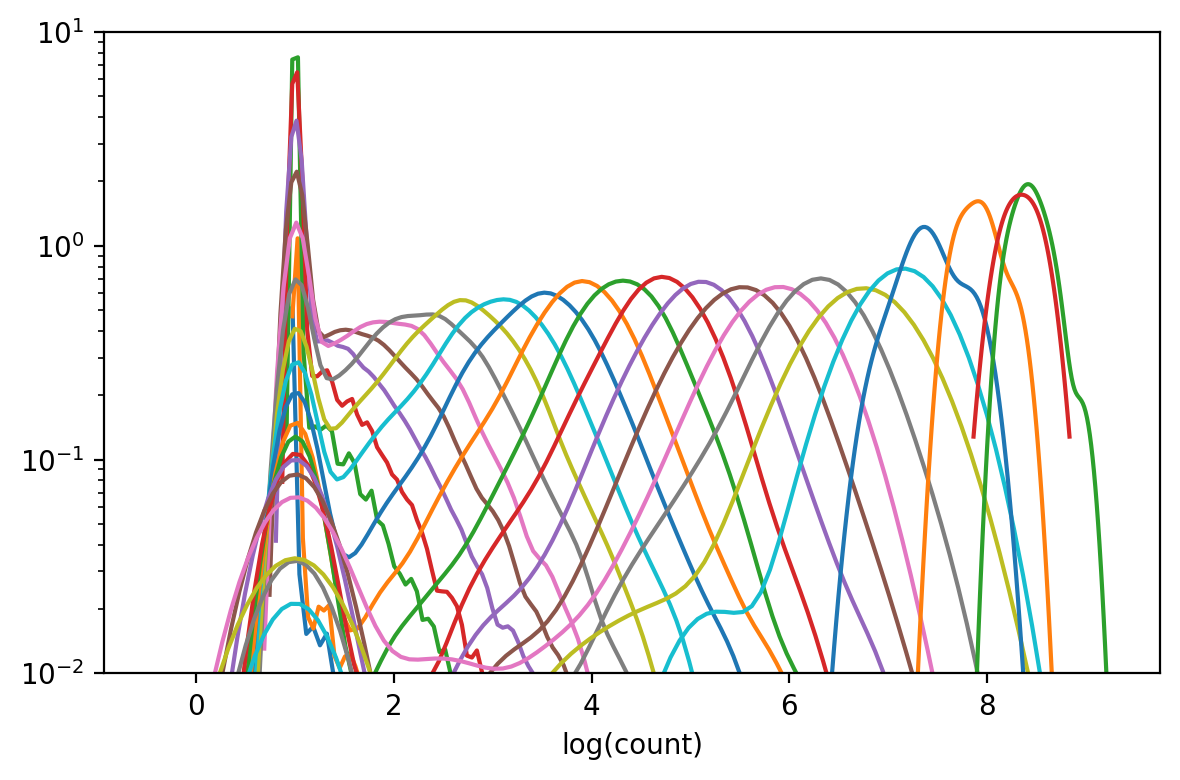

In [10]:
plt.figure(figsize=(6, 4), dpi=200)
ub = 0.5
while True:
    lb, ub = ub, ub * 1.5
    mask = (lb <= X) & (X < ub)
    if not mask.any():
        break
    sns.kdeplot(Y[mask].numpy())
plt.xlabel("log(count)")
plt.yscale("log")
plt.ylim(0.01, 10)
plt.tight_layout()

Some observations:
1. All the data is zero-inflated.
2. For intermediate values, data appears to have exponential tails on both sides. These tails are heavier than squared exponential tails of Poisson.

It looks like we can match the heavy tailed behavior with Pyro's [binomial_dist()](http://docs.pyro.ai/en/dev/contrib.epidemiology.html#pyro.contrib.epidemiology.distributions.binomial_dist) using a constant `overdispersion` parameter of about 0.7 (inference should learn this parameter from data).

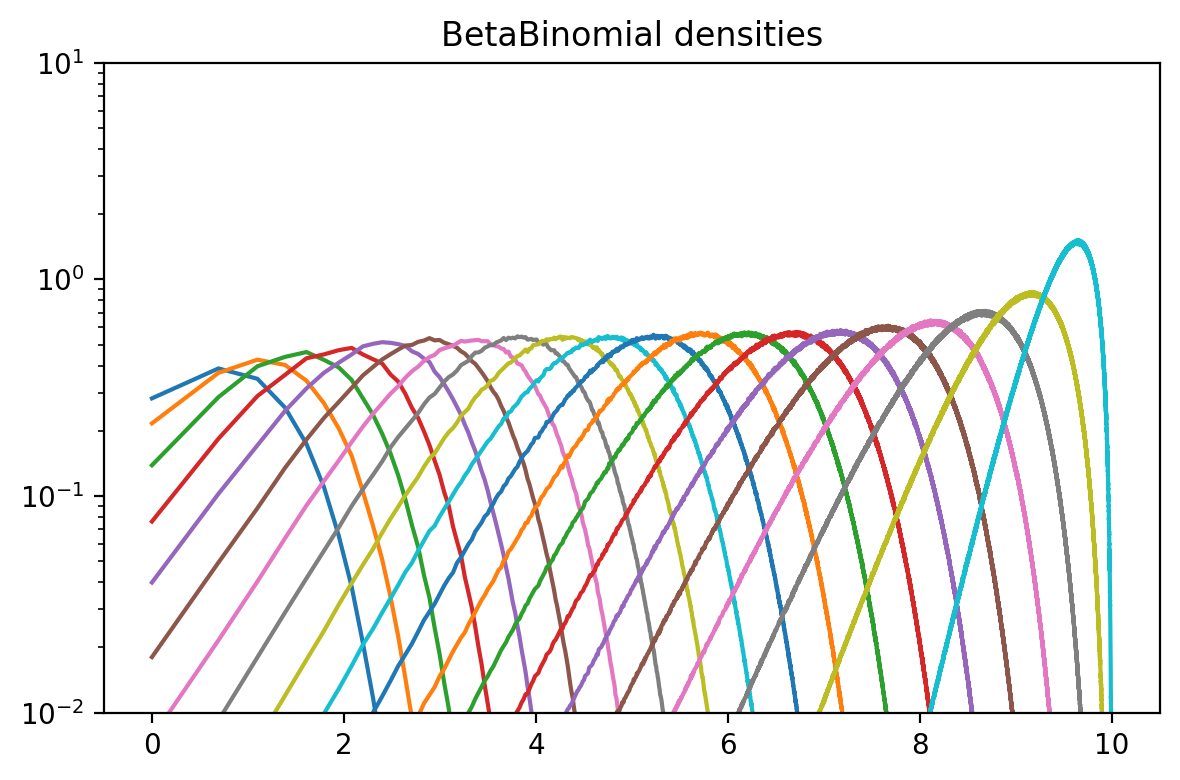

In [11]:
N = int(math.exp(10))
X = torch.arange(1., N)
X_log = X.log()
plt.figure(figsize=(6, 4), dpi=200)
for i in torch.linspace(0.05, 0.95, 20):
    p = N ** i / N
    Y = binomial_dist(N, p, overdispersion=0.7).log_prob(X).exp() * X
    plt.plot(X_log, Y)
plt.yscale("log")
plt.ylim(0.01, 10)
plt.title("BetaBinomial densities")
plt.tight_layout()

Note the tails of `binomial_dist()` are skewed relative to our pairwise statistics, but I believe this is an artifact of the statistic: samples from `binomial_dist()` should display the same non-skewed statistic.


What about the Normal approximation made during relaxed inference? Does it match the tail behavior?

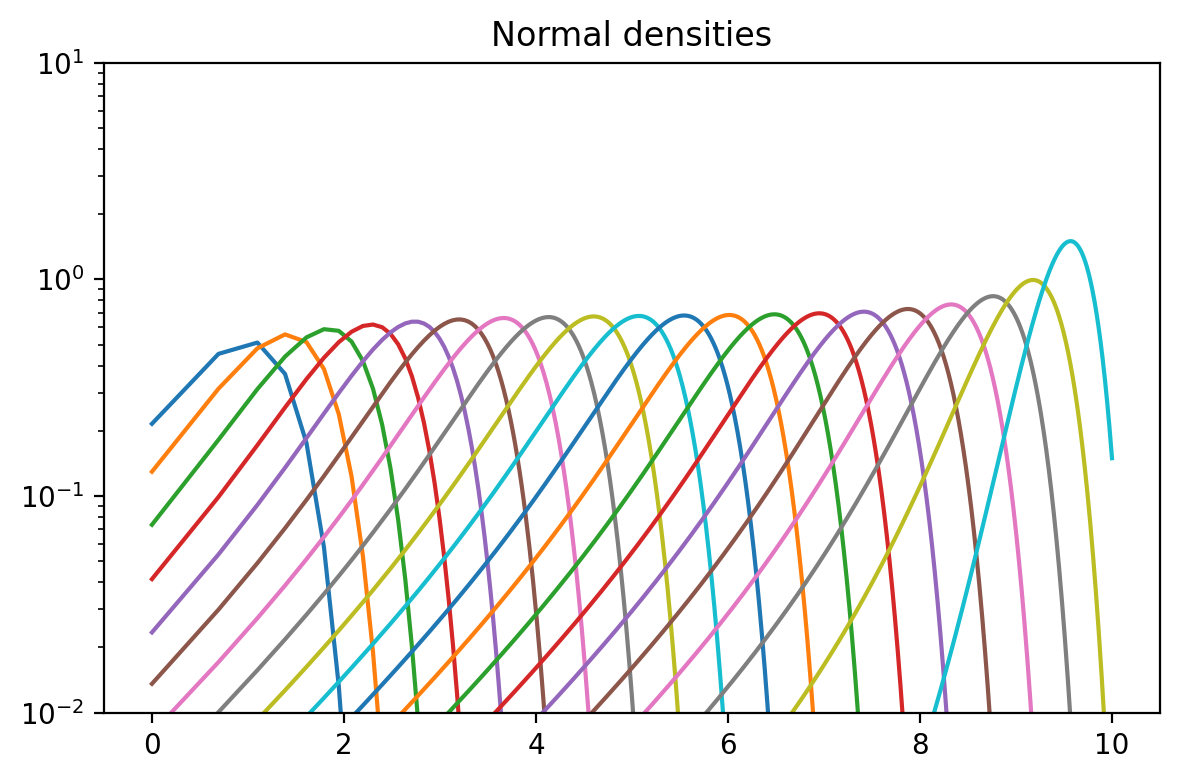

In [12]:
N = int(math.exp(10))
X = torch.arange(1., N)
X_log = X.log()
plt.figure(figsize=(6, 4), dpi=200)
for i in torch.linspace(0.05, 0.95, 20):
    p = N ** i / N
    with set_relaxed_distributions():
        Y = binomial_dist(N, p, overdispersion=0.7).log_prob(X).exp() * X
    plt.plot(X_log, Y)
plt.yscale("log")
plt.ylim(0.01, 10)
plt.title("Normal densities")
plt.tight_layout()

How well do the BetaBinomial and Normal distributions agree?

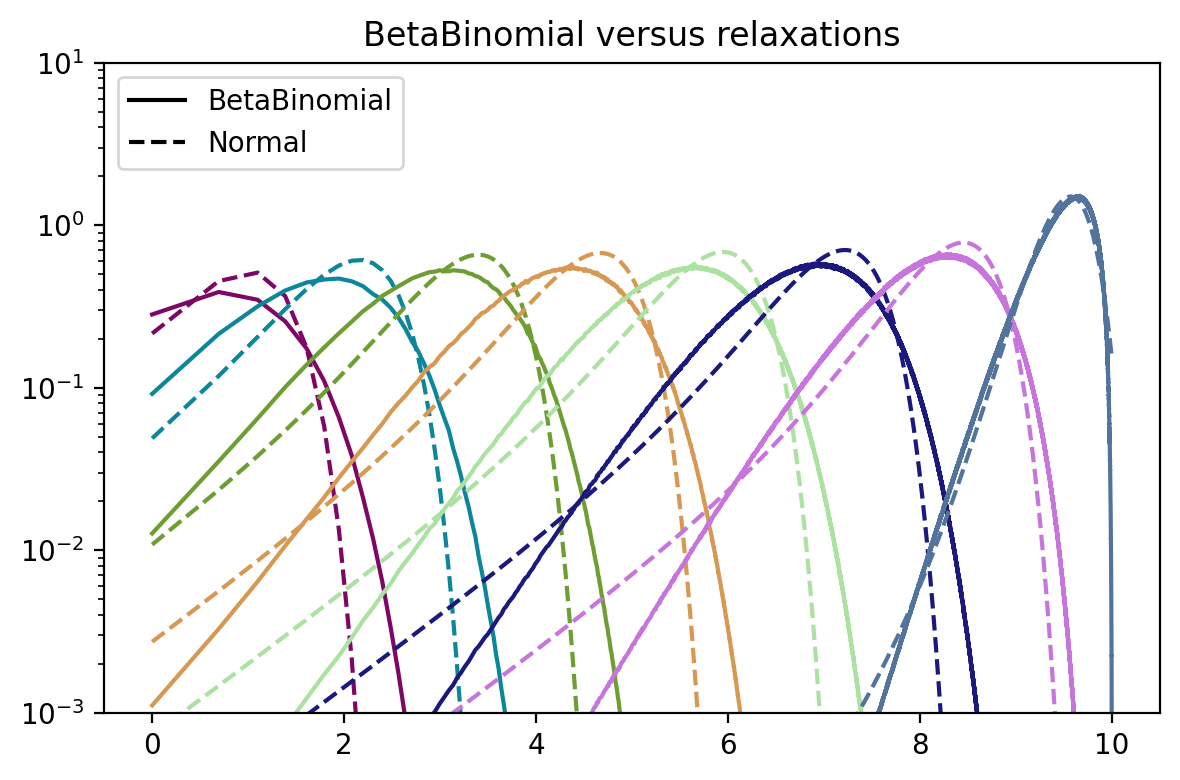

In [13]:
N = int(math.exp(10))
X = torch.arange(1., N)
X_log = X.log()
plt.figure(figsize=(6, 4), dpi=200)
for i in torch.linspace(0.05, 0.95, 8):
    color = torch.rand(3).numpy() * 0.9
    p = N ** i / N
    d1 = binomial_dist(N, p, overdispersion=0.7)
    with set_relaxed_distributions():
        d2 = binomial_dist(N, p, overdispersion=0.7)
    # d3 = dist.StudentT(2, d1.mean, d1.variance.sqrt())
    plt.plot(X_log, d1.log_prob(X).exp() * X, c=color)
    plt.plot(X_log, d2.log_prob(X).exp() * X, c=color, linestyle="--")
    # plt.plot(X_log, d3.log_prob(X).exp() * X, c=color, linestyle="-.")
plt.plot([], color="k", linestyle="-", label="BetaBinomial")
plt.plot([], color="k", linestyle="--", label="Normal")
# plt.plot([], color="k", linestyle="-.", label="StudentT")
plt.yscale("log")
plt.ylim(0.001, 10)
plt.legend(loc="upper left")
plt.title("BetaBinomial versus relaxations")
plt.tight_layout()

It looks like the Normal relaxation does not faithfully preserve the skew of the BetaBinomial, but the data seems to be skewed in between BetaBinomial and Normal.

We could further fit the zero-inflation, using Pyro's [ZeroInflatedDistribution](http://docs.pyro.ai/en/stable/distributions.html#pyro.distributions.ZeroInflatedDistribution). How does the zero inflation probability depend on scale?

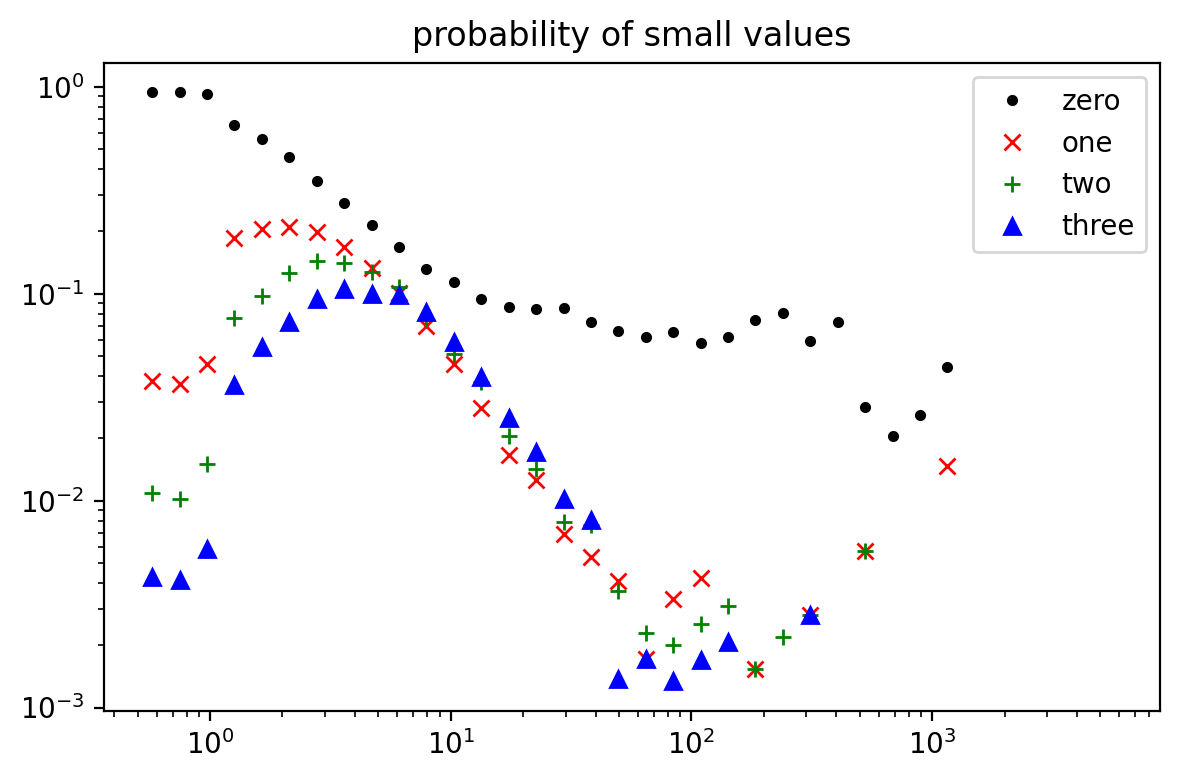

In [14]:
X = (data[:, :-2] + data[:, 2:]).div(2).reshape(-1)
X = X + torch.rand(X.shape)
Y = data[:, 1:-1].reshape(-1)
xs = []
y0s = []
y1s = []
y2s = []
y3s = []
ub = 0.5
while True:
    lb, ub = ub, ub * 1.3
    mask = (lb <= X) & (X < ub)
    if not mask.any():
        break
    xs.append((lb + ub) / 2)
    y0s.append(Y[mask].eq(0).float().mean().item())
    y1s.append(Y[mask].eq(1).float().mean().item())
    y2s.append(Y[mask].eq(2).float().mean().item())
    y3s.append(Y[mask].eq(3).float().mean().item())
    
plt.figure(figsize=(6, 4), dpi=200)
plt.plot(xs, y0s, "k.", label="zero")
plt.plot(xs, y1s, "rx", label="one")
plt.plot(xs, y2s, "g+", label="two")
plt.plot(xs, y3s, "b^", label="three")
plt.xscale("log")
plt.yscale("log")
plt.title("probability of small values")
plt.legend(loc="upper right")
plt.tight_layout()

I'm guessing the `1/x` decay on the left is due to usual Beta-Binomial behavior. On the right there is persistent small data. Maybe instead of zero inflation we can mix with an geometric distribution with small constant mean like 0.5.

Do we need a `BoundedGeometric` distribution, or would a particular instance of `BetaBinomial` suffice (in which case we could use a [MixtureSameFamily](https://pytorch.org/docs/stable/distributions.html#mixturesamefamily))? Actually it is probably cheaper to implement a `BoundedGeometric` and avoid the expense of `BetaBinomial`. Under moment-matching interpretation, we could reinterpret this as a `MixtureSameFamily` of `Normal` distributions, one at small values and one around large values.

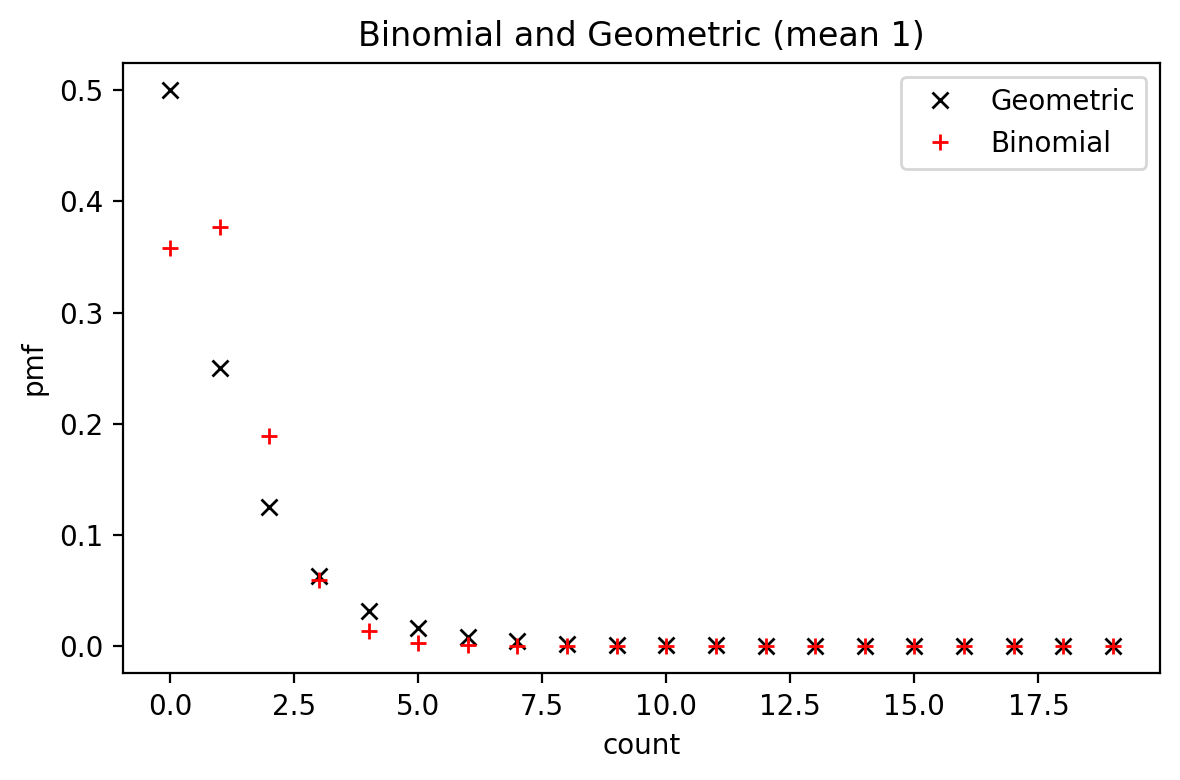

In [15]:
N = 20
X = torch.arange(20.)
geom = dist.Geometric(0.5).log_prob(X).exp()
binom = dist.Binomial(N, 1 / N).log_prob(X).exp()

plt.figure(figsize=(6, 4), dpi=200)
plt.plot(X, geom, "kx", label="Geometric")
plt.plot(X, binom, "r+", label="Binomial")
plt.xlabel("count")
plt.ylabel("pmf")
plt.legend(loc="upper right")
plt.title("Binomial and Geometric (mean 1)")
plt.tight_layout()